In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
# plt.rcParams['text.usetex'] = True

import seaborn as sns
sns.set_context("paper")

sns.set_style("whitegrid")

Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_1.log
Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_2.log
Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_3.log
Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_4.log
Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_5.log
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_1.csv
Found 500 speed values in CSV
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_2.csv
Found 500 speed values in CSV
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_3.csv
Found 500 speed values in CSV
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_4.csv
Found 500 speed values in CSV
Parsing CSV file: /

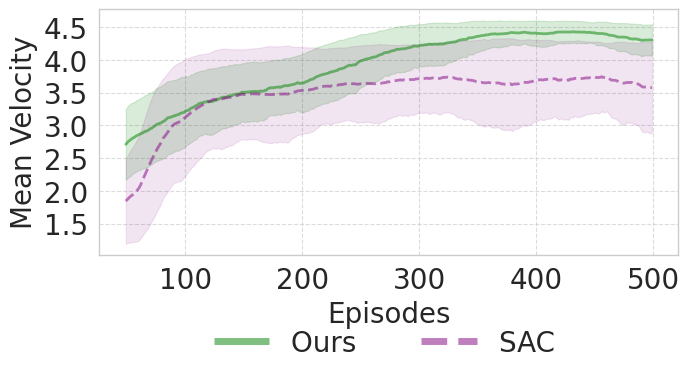

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

returns = []

def get_returns(reward_type, log_num, env_type, log_file_path):
    # Path to your log file
    print(f"Processing {log_file_path}")
    
    # Initialize a list to store the extracted data
    returns_mean_data = []
    
    # Regular expression pattern to find the training/Returns Mean entry
    pattern = re.compile(r'training/env_infos/average/vel Mean\s+([-]?\d*\.?\d*)')
    
    ct = 0
    # Read the log file
    try:
        with open(log_file_path, 'r') as file:
            for line in file:
                match = pattern.search(line)
                if match:
                    ct += 1
                    returns_mean = float(match.group(1))
                    returns_mean_data.append(returns_mean)
    except FileNotFoundError:
        print(f"Error: File {log_file_path} not found.")
        return None
    
    if not returns_mean_data:
        print("No matches found in the log file.")
        return None
    
    # Create a DataFrame
    df = pd.DataFrame(returns_mean_data, columns=['training/env_infos/average/vel Mean'])
    returns = df.values.reshape(1, -1)[0]
    return returns

def parse_csv_log(csv_file_path):
    """
    Parse the CSV log file to extract action_throttle values
    """
    print(f"Parsing CSV file: {csv_file_path}")
    try:
        # Read CSV file
        df = pd.read_csv(csv_file_path)
        
        # Check if action_throttle column exists
        if 'action_throttle' in df.columns:
            throttle_values = df['speed'].values
            print(f"Found {len(throttle_values)} speed values in CSV")
            return throttle_values
        else:
            print("No action_throttle column found in CSV")
            return None
            
    except FileNotFoundError:
        print(f"Error: CSV File {csv_file_path} not found.")
        return None
    except Exception as e:
        print(f"Error parsing CSV: {str(e)}")
        return None

def smoothen(arr, smoothing_window=100):
    smoothed_arr = (pd.Series(arr)
        .rolling(smoothing_window, min_periods=smoothing_window)
        .mean()
        )
    return smoothed_arr.values

def generate_plot(rew2_mean, rew2_std, sac_mean=None, sac_std=None, save_path=""):
    rew2_xs = np.arange(len(rew2_mean))
    
    fig, ax = plt.subplots(figsize=(7,4))
    
    # Plot rew2 data
    plt.plot(rew2_xs, rew2_mean, c="g", label="Ours ", linewidth=2, alpha=0.5)
    plt.fill_between(rew2_xs,
                    rew2_mean - rew2_std,
                    rew2_mean + rew2_std,
                    color="g", alpha=0.15)
    
    # Plot SAC data if provided
    if sac_mean is not None and sac_std is not None:
        sac_xs = np.arange(len(sac_mean))
        plt.plot(sac_xs, sac_mean, c="purple", label="SAC ", linewidth=2, alpha=0.5, linestyle='--')
        plt.fill_between(sac_xs,
                        sac_mean - sac_std,
                        sac_mean + sac_std,
                        color="purple", alpha=0.1)
    
    leg = plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", 
               ncol=2, frameon=False, fancybox=False, shadow=False,
               fontsize=20)
    for line in leg.get_lines():
        line.set_linewidth(5.0)
        line.set_solid_capstyle('butt')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("Episodes", fontsize=20)
    plt.ylabel("Mean Velocity", fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{save_path}.png", dpi=200)
    plt.show()

# Process original log files for rew2 only
returns_1 = []
for idx in range(1,6):
    reward_type = "rew2"
    env_type = "road"
    log_num = str(idx)
    log_file_path = f"/home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_{env_type}_{reward_type}_{log_num}.log"
    returns_1.append(get_returns(reward_type, log_num, env_type, log_file_path))
returns_r1_mean = np.mean(returns_1, axis=0)
returns_r1_std = np.std(returns_1, axis=0)

# Process SAC CSV files
sac_returns = []
base_path = "/home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road"  # Adjust if needed
for idx in range(1, 6):  # For debug_road_sac_1.csv to debug_road_sac_3.csv
    csv_file_path = f"{base_path}/debug_road_sac_{idx}.csv"
    sac_data = parse_csv_log(csv_file_path)
    if sac_data is not None:
        sac_returns.append(sac_data)

# Calculate mean and std for SAC data if available
sac_mean = None
sac_std = None
if sac_returns:
    # Ensure all arrays have the same length by truncating to the shortest length
    min_length = min(len(arr) for arr in sac_returns)
    sac_returns_truncated = [arr[:min_length] for arr in sac_returns]
    sac_mean = np.mean(sac_returns_truncated, axis=0)
    sac_std = np.std(sac_returns_truncated, axis=0)
    print(f"SAC data processed: Mean shape {sac_mean.shape}, Std shape {sac_std.shape}")
else:
    print("No SAC data available to plot")

# Smooth the data
WIN_SIZE = 50
means_r1, stds_r1 = smoothen(returns_r1_mean, WIN_SIZE), smoothen(returns_r1_std, WIN_SIZE)

# Smooth SAC data if available
sac_smooth_mean = None
sac_smooth_std = None
if sac_mean is not None and sac_std is not None:
    sac_smooth_mean = smoothen(sac_mean, WIN_SIZE)
    sac_smooth_std = smoothen(sac_std, WIN_SIZE)

# Plot only rew2 and SAC data
generate_plot(means_r1, stds_r1, sac_smooth_mean, sac_smooth_std, "result_plot_rew2_with_sac")


Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_1.log
Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_2.log
Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_3.log
Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_4.log
Processing /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_5.log
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_1.csv
Found 500 throttle values in CSV
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_2.csv
Found 500 throttle values in CSV
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_3.csv
Found 500 throttle values in CSV
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_4.csv
Found 500 throttle values in CSV
Parsing

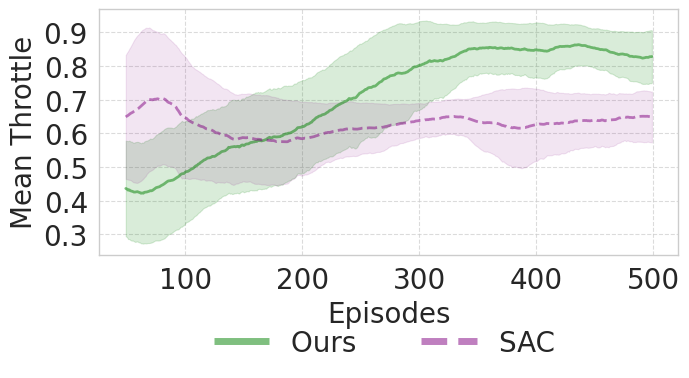

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

returns = []

def get_returns(reward_type, log_num, env_type, log_file_path):
    # Path to your log file
    print(f"Processing {log_file_path}")
    
    # Initialize a list to store the extracted data
    returns_mean_data = []
    
    # Regular expression pattern to find the training/Returns Mean entry
    pattern = re.compile(r'training/env_infos/average/action_throttle Mean\s+([-]?\d*\.?\d*)')
    
    ct = 0
    # Read the log file
    try:
        with open(log_file_path, 'r') as file:
            for line in file:
                match = pattern.search(line)
                if match:
                    ct += 1
                    returns_mean = float(match.group(1))
                    returns_mean_data.append(returns_mean)
    except FileNotFoundError:
        print(f"Error: File {log_file_path} not found.")
        return None
    
    if not returns_mean_data:
        print("No matches found in the log file.")
        return None
    
    # Create a DataFrame
    df = pd.DataFrame(returns_mean_data, columns=['training/env_infos/average/action_throttle Mean'])
    returns = df.values.reshape(1, -1)[0]
    return returns

def parse_csv_log(csv_file_path):
    """
    Parse the CSV log file to extract action_throttle values
    """
    print(f"Parsing CSV file: {csv_file_path}")
    try:
        # Read CSV file
        df = pd.read_csv(csv_file_path)
        
        # Check if action_throttle column exists
        if 'action_throttle' in df.columns:
            throttle_values = df['action_throttle'].values
            print(f"Found {len(throttle_values)} throttle values in CSV")
            return throttle_values
        else:
            print("No action_throttle column found in CSV")
            return None
            
    except FileNotFoundError:
        print(f"Error: CSV File {csv_file_path} not found.")
        return None
    except Exception as e:
        print(f"Error parsing CSV: {str(e)}")
        return None

def smoothen(arr, smoothing_window=100):
    smoothed_arr = (pd.Series(arr)
        .rolling(smoothing_window, min_periods=smoothing_window)
        .mean()
        )
    return smoothed_arr.values

def generate_plot(rew2_mean, rew2_std, sac_mean=None, sac_std=None, save_path=""):
    rew2_xs = np.arange(len(rew2_mean))
    
    fig, ax = plt.subplots(figsize=(7,4))
    
    # Plot rew2 data
    plt.plot(rew2_xs, rew2_mean, c="g", label="Ours ", linewidth=2, alpha=0.5)
    plt.fill_between(rew2_xs,
                    rew2_mean - rew2_std,
                    rew2_mean + rew2_std,
                    color="g", alpha=0.15)
    
    # Plot SAC data if provided
    if sac_mean is not None and sac_std is not None:
        sac_xs = np.arange(len(sac_mean))
        plt.plot(sac_xs, sac_mean, c="purple", label="SAC ", linewidth=2, alpha=0.5, linestyle='--')
        plt.fill_between(sac_xs,
                        sac_mean - sac_std,
                        sac_mean + sac_std,
                        color="purple", alpha=0.1)
    
    leg = plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", 
               ncol=2, frameon=False, fancybox=False, shadow=False,
               fontsize=20)
    for line in leg.get_lines():
        line.set_linewidth(5.0)
        line.set_solid_capstyle('butt')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel("Episodes", fontsize=20)
    plt.ylabel("Mean Throttle", fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{save_path}.png", dpi=200)
    plt.show()

# Process original log files for rew2 only
returns_1 = []
for idx in range(1,6):
    reward_type = "rew2"
    env_type = "road"
    log_num = str(idx)
    log_file_path = f"/home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_{env_type}_{reward_type}_{log_num}.log"
    returns_1.append(get_returns(reward_type, log_num, env_type, log_file_path))
returns_r1_mean = np.mean(returns_1, axis=0)
returns_r1_std = np.std(returns_1, axis=0)

# Process SAC CSV files
sac_returns = []
base_path = "/home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road"  # Adjust if needed
for idx in range(1, 6):  # For debug_road_sac_1.csv to debug_road_sac_3.csv
    csv_file_path = f"{base_path}/debug_road_sac_{idx}.csv"
    sac_data = parse_csv_log(csv_file_path)
    if sac_data is not None:
        sac_returns.append(sac_data)

# Calculate mean and std for SAC data if available
sac_mean = None
sac_std = None
if sac_returns:
    # Ensure all arrays have the same length by truncating to the shortest length
    min_length = min(len(arr) for arr in sac_returns)
    sac_returns_truncated = [arr[:min_length] for arr in sac_returns]
    sac_mean = np.mean(sac_returns_truncated, axis=0)
    sac_std = np.std(sac_returns_truncated, axis=0)
    print(f"SAC data processed: Mean shape {sac_mean.shape}, Std shape {sac_std.shape}")
else:
    print("No SAC data available to plot")

# Smooth the data
WIN_SIZE = 50
means_r1, stds_r1 = smoothen(returns_r1_mean, WIN_SIZE), smoothen(returns_r1_std, WIN_SIZE)

# Smooth SAC data if available
sac_smooth_mean = None
sac_smooth_std = None
if sac_mean is not None and sac_std is not None:
    sac_smooth_mean = smoothen(sac_mean, WIN_SIZE)
    sac_smooth_std = smoothen(sac_std, WIN_SIZE)

# Plot only rew2 and SAC data
generate_plot(means_r1, stds_r1, sac_smooth_mean, sac_smooth_std, "result_plot_rew2_with_sac")


Starting processing for /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_1.log
Starting processing for /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_2.log
Starting processing for /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_3.log
Starting processing for /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_4.log
Starting processing for /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_rew2_5.log
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_1.csv
Found 500 velocity and 500 distance values in CSV
Parsing CSV file: /home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_road_sac_2.csv
Found 500 velocity and 500 distance values in CSV


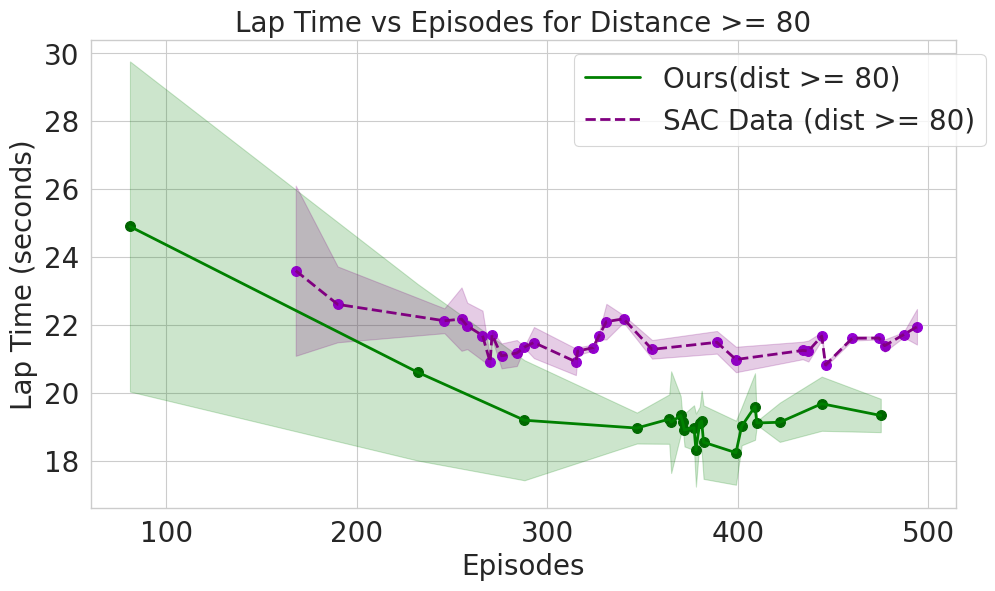

In [6]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def smoothen(arr, smoothing_window=70):
    smoothed_arr = (pd.Series(arr)
        .rolling(smoothing_window, min_periods=smoothing_window)
        .mean()
        )
    return smoothed_arr.values

def get_metrics(reward_type, log_num, env_type, log_file_path):
    print("Starting processing for", log_file_path)
    
    # Initialize lists to store the extracted data
    vel_mean_data = []
    distance_data = []
    
    # Regular expression patterns for Vel Mean and sum/distance Mean
    vel_pattern = re.compile(r'training/env_infos/average/vel Mean\s+([-]?\d*\.?\d*)')
    distance_pattern = re.compile(r'training/env_infos/sum/distance Mean\s+([-]?\d*\.?\d*)')
    
    vel_ct = 0
    dist_ct = 0
    # Read the log file
    try:
        with open(log_file_path, 'r') as file:
            for line in file:
                vel_match = vel_pattern.search(line)
                if vel_match:
                    vel_ct += 1
                    vel_mean = float(vel_match.group(1))
                    vel_mean_data.append(vel_mean)
                
                distance_match = distance_pattern.search(line)
                if distance_match:
                    dist_ct += 1
                    distance = float(distance_match.group(1))
                    distance_data.append(distance)
    except FileNotFoundError:
        print(f"Error: File {log_file_path} not found.")
        return None, None
    
    if not vel_mean_data or not distance_data:
        print(f"Warning: Missing data in {log_file_path}. Vel Mean matches: {vel_ct}, Distance Mean matches: {dist_ct}")
        return vel_mean_data if vel_mean_data else None, distance_data if distance_data else None
    
    return vel_mean_data, distance_data

def parse_csv_log(csv_file_path):
    """
    Parse the CSV log file to extract velocity and distance values
    """
    print(f"Parsing CSV file: {csv_file_path}")
    try:
        # Read CSV file
        df = pd.read_csv(csv_file_path)
        
        # Check if required columns exist (assuming columns are named 'vel' and 'distance')
        if 'speed' in df.columns and 'distance' in df.columns:
            vel_values = df['speed'].values
            distance_values = df['distance'].values
            print(f"Found {len(vel_values)} velocity and {len(distance_values)} distance values in CSV")
            return vel_values, distance_values
        else:
            print("Missing required columns (vel or distance) in CSV")
            return None, None
            
    except FileNotFoundError:
        print(f"Error: CSV File {csv_file_path} not found.")
        return None, None
    except Exception as e:
        print(f"Error parsing CSV: {str(e)}")
        return None, None

def calculate_lap_time(vel_mean_data, distance_data):
    # Ensure the lists are of the same length (truncate to shortest)
    min_length = min(len(vel_mean_data), len(distance_data))
    vel_mean_data = vel_mean_data[:min_length]
    distance_data = distance_data[:min_length]
    
    # Initialize list to store lap times
    lap_times_velocity = []
    
    for vel, distance in zip(vel_mean_data, distance_data):
        # Calculate lap time using velocity (distance / velocity) if velocity > 0
        if vel > 0:
            lap_time_vel = distance / vel
        else:
            lap_time_vel = float('inf')  # Handle cases where velocity is 0 or negative
        lap_times_velocity.append(lap_time_vel)
    
    return lap_times_velocity

def generate_2d_plot(epochs_rew2, lap_times_rew2_mean, lap_times_rew2_std, distance_rew2, 
                     epochs_sac, lap_times_sac_mean, lap_times_sac_std, distance_sac, 
                     save_path=""):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Filter and plot for rew2 where distance >= 80
    mask_rew2_above_80 = distance_rew2 >= 80
    if np.any(mask_rew2_above_80):
        epochs_rew2_filtered = epochs_rew2[mask_rew2_above_80]
        lap_times_rew2_filtered = lap_times_rew2_mean[mask_rew2_above_80]
        lap_times_rew2_std_filtered = lap_times_rew2_std[mask_rew2_above_80]
        
        # Plot mean line
        ax.plot(epochs_rew2_filtered, lap_times_rew2_filtered, c='green', label='Ours(dist >= 80)', linewidth=2)
        # Plot scatter points for mean
        ax.scatter(epochs_rew2_filtered, lap_times_rew2_filtered, c='darkgreen', marker='o', s=50)
        # Plot standard deviation as translucent shading
        ax.fill_between(epochs_rew2_filtered, 
                        lap_times_rew2_filtered - lap_times_rew2_std_filtered, 
                        lap_times_rew2_filtered + lap_times_rew2_std_filtered, 
                        color='green', alpha=0.2)
    
    # Filter and plot for SAC where distance >= 80
    mask_sac_above_80 = distance_sac >= 80
    if np.any(mask_sac_above_80):
        epochs_sac_filtered = epochs_sac[mask_sac_above_80]
        lap_times_sac_filtered = lap_times_sac_mean[mask_sac_above_80]
        lap_times_sac_std_filtered = lap_times_sac_std[mask_sac_above_80]
        
        # Plot mean line
        ax.plot(epochs_sac_filtered, lap_times_sac_filtered, c='purple', label='SAC Data (dist >= 80)', linewidth=2, linestyle='--')
        # Plot scatter points for mean
        ax.scatter(epochs_sac_filtered, lap_times_sac_filtered, c='darkviolet', marker='o', s=50)
        # Plot standard deviation as translucent shading
        ax.fill_between(epochs_sac_filtered, 
                        lap_times_sac_filtered - lap_times_sac_std_filtered, 
                        lap_times_sac_filtered + lap_times_sac_std_filtered, 
                        color='purple', alpha=0.2)
    
    # Set labels
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    ax.set_xlabel('Episodes', fontsize=20)
    ax.set_ylabel('Lap Time (seconds)', fontsize=20)
    ax.set_title('Lap Time vs Episodes for Distance >= 80', fontsize=20)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=20)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"{save_path}_2d_lap_time_distance.png", dpi=200)
    plt.show()

# Process multiple log files for rew2 only
lap_times_vel_rew2_all = []
distance_rew2_all = []

# Process rew2 logs
for idx in range(1, 6):
    reward_type = "rew2"
    env_type = "road"
    log_num = str(idx)
    log_file_path = f"/home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road/debug_{env_type}_{reward_type}_{log_num}.log"
    vel_mean_data, distance_data = get_metrics(reward_type, log_num, env_type, log_file_path)
    
    if vel_mean_data is not None and distance_data is not None:
        lap_times_velocity = calculate_lap_time(vel_mean_data, distance_data)
        lap_times_vel_rew2_all.append(lap_times_velocity)
        distance_rew2_all.append(distance_data)

# Process SAC CSV files
lap_times_vel_sac_all = []
distance_sac_all = []
base_path = "/home/smukh039/work/QRSAC/debug_logs_to_plot/generated_road"  # Adjust if needed
for idx in range(1, 3):  # For debug_road_sac_1.csv to debug_road_sac_3.csv
    csv_file_path = f"{base_path}/debug_road_sac_{idx}.csv"
    vel_data, distance_data = parse_csv_log(csv_file_path)
    
    if vel_data is not None and distance_data is not None:
        lap_times_velocity = calculate_lap_time(vel_data, distance_data)
        lap_times_vel_sac_all.append(lap_times_velocity)
        distance_sac_all.append(distance_data)

# Calculate mean and std across runs for rew2 and SAC
if lap_times_vel_rew2_all and lap_times_vel_sac_all:
    # Ensure all arrays are of the same length (truncate to shortest length if necessary)
    min_length_rew2 = min(len(run) for run in lap_times_vel_rew2_all)
    min_length_sac = min(len(run) for run in lap_times_vel_sac_all)
    min_length_dist_rew2 = min(len(run) for run in distance_rew2_all)
    min_length_dist_sac = min(len(run) for run in distance_sac_all)
    
    lap_times_vel_rew2_all = [run[:min_length_rew2] for run in lap_times_vel_rew2_all]
    lap_times_vel_sac_all = [run[:min_length_sac] for run in lap_times_vel_sac_all]
    distance_rew2_all = [run[:min_length_dist_rew2] for run in distance_rew2_all]
    distance_sac_all = [run[:min_length_dist_sac] for run in distance_sac_all]

    # Convert to numpy arrays for calculation
    lap_times_vel_rew2_array = np.array(lap_times_vel_rew2_all)
    lap_times_vel_sac_array = np.array(lap_times_vel_sac_all)
    distance_rew2_array = np.array(distance_rew2_all)
    distance_sac_array = np.array(distance_sac_all)
    
    # Replace infinities with a large value for plotting purposes
    large_value = 1e6  # Arbitrary large value to represent invalid lap times
    lap_times_vel_rew2_array = np.where(lap_times_vel_rew2_array == float('inf'), large_value, lap_times_vel_rew2_array)
    lap_times_vel_sac_array = np.where(lap_times_vel_sac_array == float('inf'), large_value, lap_times_vel_sac_array)
    
    # Calculate mean and std for rew2
    lap_times_vel_rew2_mean = np.mean(lap_times_vel_rew2_array, axis=0)
    lap_times_vel_rew2_std = np.std(lap_times_vel_rew2_array, axis=0)
    distance_rew2_mean = np.mean(distance_rew2_array, axis=0)
    
    # Calculate mean and std for SAC
    lap_times_vel_sac_mean = np.mean(lap_times_vel_sac_array, axis=0)
    lap_times_vel_sac_std = np.std(lap_times_vel_sac_array, axis=0)
    distance_sac_mean = np.mean(distance_sac_array, axis=0)

    # Apply smoothing with window size 70 for better visualization
    WIN_SIZE = 1
    lap_times_vel_rew2_mean = smoothen(lap_times_vel_rew2_mean, WIN_SIZE)
    lap_times_vel_rew2_std = smoothen(lap_times_vel_rew2_std, WIN_SIZE)
    distance_rew2_mean = smoothen(distance_rew2_mean, WIN_SIZE)
    lap_times_vel_sac_mean = smoothen(lap_times_vel_sac_mean, WIN_SIZE)
    lap_times_vel_sac_std = smoothen(lap_times_vel_sac_std, WIN_SIZE)
    distance_sac_mean = smoothen(distance_sac_mean, WIN_SIZE)
    
    # Generate epochs (x-axis)
    epochs_rew2 = np.arange(len(lap_times_vel_rew2_mean))
    epochs_sac = np.arange(len(lap_times_vel_sac_mean))
    
    # Generate 2D plot with std dev for rew2 and SAC
    generate_2d_plot(epochs_rew2, lap_times_vel_rew2_mean, lap_times_vel_rew2_std, distance_rew2_mean, 
                     epochs_sac, lap_times_vel_sac_mean, lap_times_vel_sac_std, distance_sac_mean, 
                     save_path="lap_time_plot_rew2_sac")
else:
    print("No data to plot for rew2 or SAC.")
